## Dataset1_Global_mean_temp

In [207]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

In [208]:
df = pd.read_csv('Dataset1_global_mean_temp.csv', names = ["global mean temp"])

In [209]:
df.head()

,global mean temp
0,-0.36
1,-0.30
2,-0.23
3,-0.23
4,-0.51


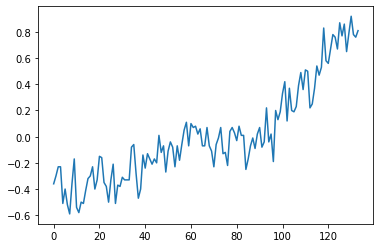

In [210]:
plt.plot(df['global mean temp'])

From data plot, we can say that it is a non-stationary data series.

**ADF Test**

In [211]:
def adf_test(atr):
    #Perform Dickey-Fuller test:
    timeseries = df[atr].dropna()
    print ('Results of Dickey-Fuller Test for ',atr,'\n')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

#apply adf test on the series
adf_test('global mean temp')

Results of Dickey-Fuller Test for  global mean temp 

Test Statistic                   0.330692
p-value                          0.978710
#Lags Used                       3.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


ADF test: The test statistic is greater than the critical value, so we fail to reject the null hypothesis. So it is non-stationary series.
Also P value is greater than 0.05 so, from that also we can say it in non-stationary. 

**KPSS Test**

In [212]:
def kpss_test(atr):
    timeseries = df[atr].dropna()
    print ('Results of KPSS Test for ',atr)
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
kpss_test('global mean temp')

Results of KPSS Test for  global mean temp
Test Statistic            0.937789
p-value                   0.010000
Lags Used                13.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


KPSS Test: The test statistic is greater than the critical value so we can reject the null hypothesis. So it is non-stationary series.


**Differencing with period 1 to make non-stationary data to stationary dataseries.**

In [213]:
df['Diff'] = df['global mean temp'].diff(periods=1)

In [214]:
df

,global mean temp,Diff
0,-0.36,NaN
1,-0.30,0.06
2,-0.23,0.07
3,-0.23,0.00
4,-0.51,-0.28
...,...,...
129,0.79,0.14
130,0.92,0.13
131,0.78,-0.14
132,0.76,-0.02


In [215]:
adf_test('Diff')

Results of Dickey-Fuller Test for  Diff 

Test Statistic                -1.130253e+01
p-value                        1.296867e-20
#Lags Used                     2.000000e+00
Number of Observations Used    1.300000e+02
Critical Value (1%)           -3.481682e+00
Critical Value (5%)           -2.884042e+00
Critical Value (10%)          -2.578770e+00
dtype: float64


p value is less than the 0.05 so data is stationary.

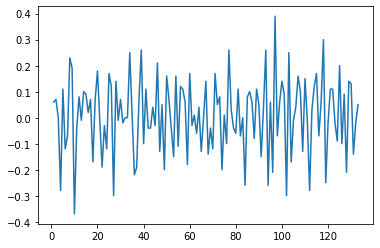

In [216]:
df['Diff'].plot()
plt.show()

In [217]:
data1 = df.iloc[:,0].values
dataset_array1 = [data1[0::1],data1[0::2],data1[0::4],data1[0::8],data1[0::12],data1[0::24]]

In [218]:
def plotting_function(MSE,MAE,name):
  interval = [1,2,3,4,5,6]

  barWidth = 0.25  
  r1 = np.arange(len(interval))
  r2 = [x + barWidth for x in r1]
  
  # Make the plot
  plt.bar(r1, MSE, color='b', width=barWidth, label='MSE')
  plt.bar(r2, MAE, color='g', width=barWidth, label='MAE')

  plt.xlabel('interval', fontweight='bold')
  plt.xticks([r + barWidth for r in range(len(interval))], ['1', '2', '4', '8', '12','24'])
  plt.title('MSE and MAE plot for '+(name))
  plt.legend()
  plt.show()
 

**single exponential smoothing**

In [219]:
def single_exp(data,interval,alpha):
  array1=data
  
  fv = np.array([None] * len(array1))
  for i in range(interval):
    fv[i]=array1[i]
   
  for i in range(interval, len(array1)):
    fv[i] = alpha * array1[i-interval] + (1 - alpha) * fv[i - interval]
  array = array1-fv
  arr = pd.DataFrame.from_dict({"global mean temp":array1,"Forecasted value":fv,"Error":array})
  return arr

In [220]:
interval = [1,2,4,8,12,24]
mse1=[]
mae1=[]
for i in interval:
  a = single_exp(df.iloc[:,0],i,0.9)
  mse_val = ((a.Error)**2).sum()/(len(a.Error)-i)
  mae_val = (abs(a.Error)).sum()/(len(a.Error)-i)
  mse1.append(round(mse_val,6))
  mae1.append(round(mae_val,6))

print('MSE for each interval respectively \n',mse1)
print('MSE for each interval respectively \n',mae1)

MSE for each interval respectively 
 [0.019031, 0.025219, 0.026015, 0.0361, 0.052196, 0.113739]
MSE for each interval respectively 
 [0.110927, 0.128802, 0.130324, 0.153946, 0.187459, 0.271281]


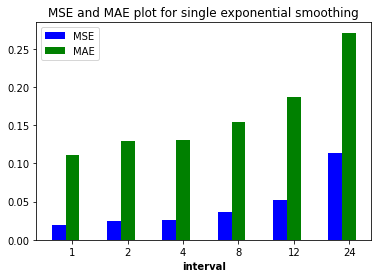

In [221]:
plotting_function(mse1,mae1,'single exponential smoothing')

**Double Exponential Smoothing**

In [222]:
def double_exp(data,interval,alpha,beta):
  array=data
  f = np.array([None] * len(array))
  a = np.array([None] * len(array))
  b = np.array([None] * len(array))
  

  f[0]=data[0]
  a[0] = array[0]
  b[0] = (array[(len(array)-1)] - array[0])/(len(array)-1)

  if interval<2:
    f[1] = a[0]+b[0]
    for i in range(2, len(array)):
      a[i-1] = alpha*array[i-1] + (1-alpha)*(a[i-2]+b[i-2])
      b[i-1] = beta*(a[i-1]-a[i-2]) + (1-beta)*b[i-2]
      f[i] = a[i-1] + b[i-1]
    arr = pd.DataFrame.from_dict({"global mean temp":array,"Forecasted value":f,"Error":array-f})
  else:
    for i in range(2,interval):
      a[i-1] = alpha*array[i-1] + (1-alpha)*(a[i-2]+b[i-2])
      b[i-1] = beta*(a[i-1]-a[i-2]) + (1-beta)*b[i-2]

    for i in range(1,interval):
      f[i] = a[i-1] + b[i-1]

    for i in range(interval, len(array)):
      a[i-1] = alpha*array[i-1] + (1-alpha)*(a[i-2]+b[i-2])
      b[i-1] = beta*(a[i-1]-a[i-2]) + (1-beta)*b[i-2]
      f[i] = a[i-1] + b[i-1]
    arr = pd.DataFrame.from_dict({"global mean temp":array,"Forecasted value":f,"Error":array-f})
  return arr

In [223]:
interval = [1,2,4,8,12,24]
mse2=[]
mae2=[]
for i in interval:
  a = double_exp(df.iloc[:,0],i,0.9,0.01)
  mse_val = ((a.Error)**2).sum()/(len(a.Error)-i)
  mae_val = (abs(a.Error)).sum()/(len(a.Error)-i)
  mse2.append(round(mse_val,6))
  mae2.append(round(mae_val,6))

print('MSE for each interval respectively \n',mse2)
print('MSE for each interval respectively \n',mae2)

MSE for each interval respectively 
 [0.019111, 0.019255, 0.019552, 0.020172, 0.020834, 0.023106]
MSE for each interval respectively 
 [0.110918, 0.111758, 0.113478, 0.11708, 0.120919, 0.13411]


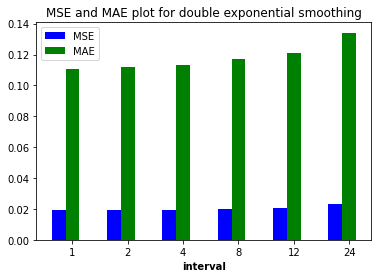

In [224]:
plotting_function(mse2,mae2,'double exponential smoothing')

**Triple Exponential Smoothing**

In [225]:
def initial_trend(data, season_len):
    sum = 0.0
    for i in range(season_len):
        sum += float(data[i+season_len] - data[i]) / season_len
    return sum / season_len

def initial_seasonal(data, season_len):
  seasonals = {}
  season_averages = []
  n_seasons = int(len(data)/season_len)
  # compute season averages
  for j in range(n_seasons):
    avg = ((data[(season_len*j):(season_len*j)+season_len]).sum())/float(season_len)
    season_averages.append(avg)
  # initial values
  for i in range(season_len):
    sum = 0.0
    for j in range(n_seasons):
      sum += data[season_len*j+i]-season_averages[j]
    seasonals[i] = sum/n_seasons
  return seasonals

def triple_exp(data, season_len, alpha, beta, gamma, n_preds):
  result = []
  error = []
  seasonals = initial_seasonal(data, season_len)
  for i in range(len(data)+n_preds):
    if i == 0: # initial values
      smooth = data[0]
      trend = initial_trend(data, season_len)
      result.append(data[0])
      continue
    if i >= len(data): # we are forecasting
      m = i - len(data) + 1
      result.append((smooth + m*trend) + seasonals[i%season_len])
    else:
      val = data[i]
      last_smooth, smooth = smooth, alpha*(val-seasonals[i%season_len]) + (1-alpha)*(smooth+trend)
      trend = beta * (smooth-last_smooth) + (1-beta)*trend
      seasonals[i%season_len] = gamma*(val-smooth) + (1-gamma)*seasonals[i%season_len]
      forecast = smooth+trend+seasonals[i%season_len]
      error = data - forecast
      result.append(forecast)
      
  SE = np.square(error)
  SSE = 0
  for i in SE:
    SSE+= i
  mse_val = SSE/(len(data)-1)
  mae_val = np.sum(abs(error)/len(error))
  return mse_val,mae_val

In [240]:
mse3 = []
mae3 = []
final_forecasted_list = []
for dataframe in dataset_array1:
  mse_val,mae_val = triple_exp(dataframe,1,0.9,0.02,0.95,1)
  mse3.append(round(mse_val,6))
  mae3.append(round(mae_val,6))

print('MSE for each interval respectively \n',mse3)
print('MSE for each interval respectively \n',mae3)

MSE for each interval respectively 
 [0.802031, 0.808338, 0.650656, 0.645892, 0.687599, 0.484885]
MSE for each interval respectively 
 [0.814571, 0.818127, 0.717812, 0.71658, 0.700221, 0.577785]


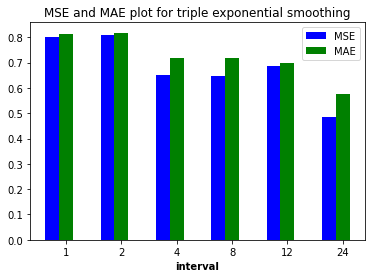

In [241]:
plotting_function(mse3,mae3,'triple exponential smoothing')

**ACF PACF Plot**

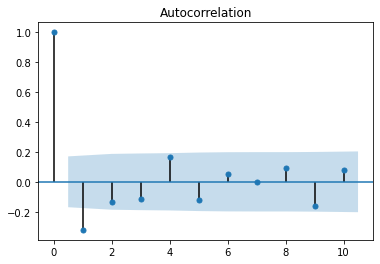

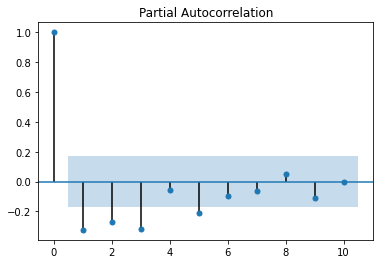

In [228]:
plot_acf(df.iloc[:,1].dropna(), lags=10)
plt.show()
plot_pacf(df.iloc[:,1].dropna(), lags=10)
plt.show()

Checking for
AR(1), AR(2), AR(3), AR(5) : from partial autocorelation plot.

MA(1) : from autocorelation plot.

pmdarima package install

In [229]:
!pip3 install pmdarima

In [230]:
import pmdarima as pm
model = pm.auto_arima(df.iloc[:,0], start_p=1, start_q=1,test='adf',max_p=5, max_q=3,m=1,d=None,seasonal=False,start_P=0, D=0, 
                      trace=True,error_action='ignore',  suppress_warnings=True,stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-172.662, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-138.203, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-150.647, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-170.641, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-139.692, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-171.777, Time=0.46 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-171.188, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-173.183, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-171.195, Time=0.40 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-172.644, Time=0.49 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-168.699, Time=0.08 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 2.485 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  

**AR model**

In [231]:
from statsmodels.tsa.arima_model import ARIMA
def ar_model(data):
  model=ARIMA(data,order=(2,0,0)).fit()
  prediction = model.fittedvalues
  error = data - prediction
  mse_val = np.sum((error)**2)/len(error)
  mae_val = np.sum(abs(error))/len(error)
  return mse_val,mae_val,prediction

In [232]:
mse4 = []
mae4 = []
final_forecasted_list = []
for dataframe in dataset_array1:
  mse_val,mae_val,prediction = ar_model(dataframe)
  mse4.append(round(mse_val,6))
  mae4.append(round(mae_val,6))
  final_forecasted_list.append(prediction)

print('MSE for each interval respectively \n',mse4)
print('MSE for each interval respectively \n',mae4)

MSE for each interval respectively 
 [0.019258, 0.024927, 254.507765, 0.03431, 0.06364, 0.112656]
MSE for each interval respectively 
 [0.109618, 0.121866, 2.8611, 0.134471, 0.193079, 0.265223]


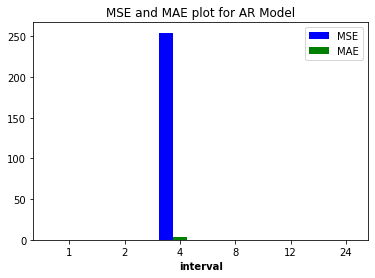

In [233]:
plotting_function(mse4,mae4,'AR Model')

**MA Model**

In [234]:
def ma_model(data):
  model=ARIMA(data,order=(0,0,2)).fit()
  prediction = model.fittedvalues
  error = data - prediction
  mse_val = np.sum((error)**2)/len(error)
  mae_val = np.sum(abs(error))/len(error)
  return mse_val,mae_val,prediction

In [235]:
mse5 = []
mae5 = []
final_forecasted_list = []
for dataframe in dataset_array1:
  mse_val,mae_val,prediction = ma_model(dataframe)
  mse5.append(round(mse_val,6))
  mae5.append(round(mae_val,6))
  final_forecasted_list.append(prediction)

print('MSE for each interval respectively \n',mse5)
print('MSE for each interval respectively \n',mae5)

MSE for each interval respectively 
 [0.039539, 0.045166, 0.045009, 0.035656, 0.063314, 0.094376]
MSE for each interval respectively 
 [0.157431, 0.170707, 0.168767, 0.151652, 0.188364, 0.277943]


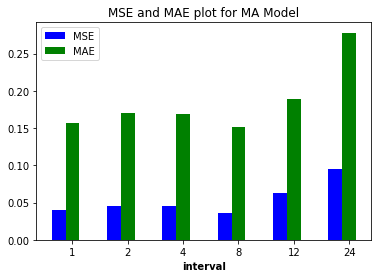

In [236]:
plotting_function(mse5,mae5,'MA Model')

**ARIMA Model**

In [237]:
def arima_model(data):
  model=ARIMA(data,order=(0,1,1)).fit()
  prediction = model.fittedvalues
  data = np.delete(data,[0])
  error = data - prediction
  mse_val = np.sum((error)**2)/len(error)
  mae_val = np.sum(abs(error))/len(error)
  return mse_val,mae_val,prediction

In [238]:
mse6 = []
mae6 = []
final_forecasted_list = []
for dataframe in dataset_array1:
  mse_val,mae_val,prediction = arima_model(dataframe)
  mse6.append(round(mse_val,6))
  mae6.append(round(mae_val,6))
  final_forecasted_list.append(prediction)

print('MSE for each interval respectively \n',mse6)
print('MSE for each interval respectively \n',mae6)

MSE for each interval respectively 
 [0.158667, 0.157589, 0.142108, 0.108257, 0.158486, 0.146731]
MSE for each interval respectively 
 [0.310911, 0.315315, 0.322333, 0.272688, 0.346297, 0.321971]


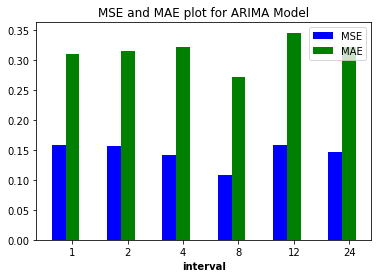

In [239]:
plotting_function(mse6,mae6,'ARIMA Model')